In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

trust_path = 'Epinions/trust_data.txt'
ratings_path = "Epinions/ratings_data.txt"

trust_data = pd.read_csv(trust_path, sep='\t')
trust_data[['ui', 'uk', 'trust']] = trust_data.iloc[:, 0].str.split(expand=True)

trust_data['ui'] = trust_data['ui'].astype(int)
trust_data['uk'] = trust_data['uk'].astype(int)
trust_data['trust'] = trust_data['trust'].astype(int)
trust_data.drop(columns=trust_data.columns[0], inplace=True)

subset_users = trust_data['ui'].unique()
subset_users = np.sort(subset_users)[:100]
trust_data_subset = trust_data[trust_data['ui'].isin(subset_users)]

subset_items = trust_data_subset['uk'].unique()
subset_items = np.sort(subset_items)[:100]
trust_data_subset = trust_data_subset[trust_data_subset['uk'].isin(subset_items)]


max_ui_idx = trust_data_subset['ui'].max()
max_uk_idx = trust_data_subset['uk'].max()

ui_uk_matrix = np.zeros((100, 100))
for _, row in trust_data_subset.iterrows():
    if(row['uk'] > 100 or row['ui'] > 100):
      continue
    ui_uk_matrix[row['ui']-1, row['uk']-1] = row['trust']

np.save('Epinions/ui_uk_matrix.npy', ui_uk_matrix)
#np.savetxt('Epinions/ui_uk_matrix.txt', ui_uk_matrix)

rating_data = pd.read_csv(ratings_path, sep='\t')
rating_data[['user_id', 'item_id', 'rating']] = rating_data.iloc[:, 0].str.split(expand=True)

rating_data['user_id'] = rating_data['user_id'].astype(int)
rating_data['item_id'] = rating_data['item_id'].astype(int)
rating_data['rating'] = rating_data['rating'].astype(int)
rating_data.drop(columns=rating_data.columns[0], inplace=True)


subset_users = rating_data['user_id'].unique()
subset_users = np.sort(subset_users)[:100]
rating_data_subset = rating_data[rating_data['user_id'].isin(subset_users)]

subset_items = rating_data_subset['item_id'].unique()
subset_items = np.sort(subset_items)[:1000]
rating_data_subset = rating_data_subset[rating_data_subset['item_id'].isin(subset_items)]

# 그냥 item 각각 100까지만 !!
# max_user_idx = rating_data_subset['user_id'].max()
# max_item_idx = rating_data_subset['item_id'].max()

train_data, test_data = train_test_split(rating_data_subset, test_size=0.2, random_state=42)

train_rating_matrix = np.zeros((100, 1000))
test_rating_matrix = np.zeros((100, 1000))

for _, row in train_data.iterrows():
    if(row['user_id'] > 100 or row['item_id'] > 1000):
      continue
    train_rating_matrix[row['user_id']-1, row['item_id']-1] = row['rating']

for _, row in test_data.iterrows():
    if(row['user_id'] > 100 or row['item_id'] > 1000):
      continue
    test_rating_matrix[row['user_id']-1, row['item_id']-1] = row['rating']


np.save('Epinions/train_rating_matrix.npy', train_rating_matrix)
np.save('Epinions/test_rating_matrix.npy', test_rating_matrix)


In [ ]:
print(trust_data_subset)

        ui  uk  trust
1161     7  91      1
1166     7  60      1
1180     7  87      1
1199     7  23      1
1208     7  59      1
...     ..  ..    ...
484285  96   1      1
485050  21  93      1
485056  21   1      1
485058  21  92      1
485059  21  59      1

[569 rows x 3 columns]


In [2]:
import numpy as np
train_rating_matrix = np.load('Epinions/train_rating_matrix.npy')
test_rating_matrix = np.load('Epinions/test_rating_matrix.npy')
ui_uk_matrix= np.load('Epinions/ui_uk_matrix.npy')

In [ ]:
ui_uk_matrix.shape
print(ui_uk_matrix)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
test_rating_matrix.shape

(100, 100)

In [3]:
nonzero_elements = (test_rating_matrix != 0)

scaled_test_rating_matrix = (test_rating_matrix[nonzero_elements] - 1) / 4.0
scaled_test_rating_matrix_full = np.zeros_like(test_rating_matrix)
scaled_test_rating_matrix_full[nonzero_elements] = scaled_test_rating_matrix

nonzero_elements = (train_rating_matrix != 0)
scaled_train_rating_matrix = (train_rating_matrix[nonzero_elements] - 1) / 4.0
scaled_train_rating_matrix_full = np.zeros_like(train_rating_matrix)
scaled_train_rating_matrix_full[nonzero_elements] = scaled_train_rating_matrix


In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# 필요한 함수들
def g(x):
  return 1 / (1 + torch.exp(-x))

def g_prime(x):
  return g(x) * (1- g(x))

class SOREC(nn.Module):
  def __init__(self, train_R = scaled_train_rating_matrix_full, test_R = scaled_test_rating_matrix_full, trust = ui_uk_matrix, l=10, lambC = 10, lambdaUVZ =0.001, learning_rate=1e-3, epochs= 5):
    '''
    SOREC
    논문에서는 gradient descent 직접 업데이트하는 방식
    구현은 pytorch의 loss.backward()
    '''
    super(SOREC, self).__init__()

    # 논문은 특이하게 m이 user 수, n이 item 수
    self.m, self.n = train_R.shape # Rating
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = l

    self.train_R = train_R # 80            (100, 1000)
    self.test_R = test_R   # 20 비율       (100, 1000)
    self.trust = trust     # trust ratings (100, 100)

    self.lr = learning_rate
    self.epoch = epochs
    self.lambdaC = lambC
    self.lambdaUVZ = lambdaUVZ # 공통으로 사용

    # 직접 gradient 각각 update
    self.U = nn.Parameter(torch.randn(self.latent_dimension, self.m)) # (l, m)
    self.Z = nn.Parameter(torch.randn(self.latent_dimension, self.m)) # (l, m)
    self.V = nn.Parameter(torch.randn(self.latent_dimension, self.n)) # (l, n)

    self.optimizer = torch.optim.Adam(self.parameters(), lr= self.lr)

  def get_complete_matrix(self):
    self.completed_rating_matrix  = torch.matmul(self.U.T, self.V)
    return self.completed_rating_matrix

  def forward_user_item(self, u):
    # user 들어올 때마다 모든 item에 대한 rating 차이 구하기
    predicted_rating = torch.matmul(self.U[:, u].T, self.V) # (l,) (l, n) => (n)
    loss = 0
    for v in range(self.n):
      # R이 있는 경우만
      if self.train_R[u, v]:
        loss += (self.train_R[u, v] - g(predicted_rating[v])) ** 2
        #print("u, v,", u, v, (self.train_R[u, v] - g(predicted_rating[v])) ** 2)

    return loss / 2

  def forward_social(self, u):
    # user 들어올 때마다 trusted user 대한 trust 차이 구하기
    predicted_trust = torch.matmul(self.U[:, u].T, self.Z) # (m)
    loss = 0
    for z in range(self.m):
      if self.trust[u, z]:
        loss += (self.trust[u, z] - g(predicted_trust[z])) ** 2

    return self.lambdaC * loss / 2

  def test_accuracy(self):
    completed_rating_matrix = torch.matmul(self.U.T, self.V)
    mae_loss = 0
    test_num = 0
    for u in range(self.m):
      for v in range(self.n):
        if self.test_R[u, v]:
          test_num += 1 # .2
          mae_loss += abs(completed_rating_matrix[u, v] - self.test_R[u, v])

    return mae_loss / test_num

  def train_accuracy(self):
    completed_rating_matrix = torch.matmul(self.U.T, self.V)
    mae_loss = 0
    train_num = 0
    for u in range(self.m):
      for v in range(self.n):
        if self.train_R[u, v]:
          train_num += 1 # .8
          mae_loss += abs(completed_rating_matrix[u, v] - self.train_R[u, v])

    return mae_loss / train_num


  def fit(self):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(self.epoch):
      total_loss = 0
      for u in range(self.m):

        # user-item matrix loss
        loss1 = self.forward_user_item(u)

        # trust matrix loss
        loss2 = self.forward_social(u)

        total_loss = loss1 + loss2 + self.lambdaUVZ * (torch.sum(self.U ** 2) + torch.sum(self.V ** 2) + torch.sum(self.Z ** 2))

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

      test_mae = self.test_accuracy()
      train_mae = self.train_accuracy()

      train_loss_list.append(train_mae)
      test_loss_list.append(test_mae)

      if epoch % 40 == 0:

        print(f'Epoch [{epoch}/{self.epoch}], total_loss: {total_loss}, train_mae: {train_mae}, test_mae: {test_mae}')


    return train_loss_list, test_loss_list


Epoch [0/200], total_loss: 11.483431816101074, train_mae: 2.22940731048584, test_mae: 2.4190123081207275
Epoch [40/200], total_loss: 1.762978434562683, train_mae: 0.37445834279060364, test_mae: 0.838713526725769
Epoch [80/200], total_loss: 1.2129321098327637, train_mae: 0.2844747304916382, test_mae: 0.7525971531867981
Epoch [120/200], total_loss: 0.8773898482322693, train_mae: 0.3227185010910034, test_mae: 0.7190210223197937
Epoch [160/200], total_loss: 0.7156668901443481, train_mae: 0.34875792264938354, test_mae: 0.710475742816925


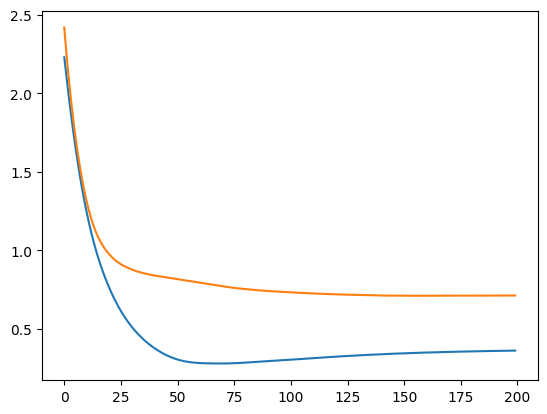

In [101]:
import matplotlib.pyplot as plt

model = SOREC(epochs = 200)

# Train the model
train_loss_list, test_loss_list = model.fit()
train_loss_list = torch.tensor(train_loss_list).detach().numpy()
test_loss_list = torch.tensor(test_loss_list).detach().numpy()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')

## 구현
 RAM이 꽉찰수록 연산 속도가 현저하게 떨어진다.
lambdaUVZ 작을수록 ovefirt 돼서 사실 잘되는 건줄 알았는데 0.001보다 0.01이 훨씬 성능 좋음

In [94]:
train_toy = np.array([
    [5, 2, 0, 3, 0, 4, 0, 0],
    [4, 3, 0, 0, 5, 0, 0, 0],
    [4, 0, 2, 0, 0, 0, 2, 4],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [5, 1, 2, 0, 4, 3, 0, 0],
    [4, 3, 0, 2, 4, 0, 3, 5]
], dtype=float)


trust_toy = np.array([
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1.0, 0.8],
            [0.8,0, 0,0,0,0],
            [0.8, 1.0, 0, 0, 0.6, 0],
            [0,0, 0.4, 0, 0, 0.8],
            [0,0,0,0,0,0]])

# Apply scaling only to nonzero elements
scaled_train_rating_matrix_toy = np.zeros_like(train_toy, dtype=float)

for i in range(6):
  for ii in range(8):
    if train_toy[i,ii]:
      scaled_train_rating_matrix_toy[i, ii] = float((train_toy[i, ii] - 1.0) / 4.0)




In [115]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# 필요한 함수들
def g(x):
  return 1 / (1 + torch.exp(-x))

def g_prime(x):
  return g(x) * (1- g(x))

class SOREC(nn.Module):
  def __init__(self, train_R = scaled_train_rating_matrix_full, test_R = scaled_test_rating_matrix_full, trust = ui_uk_matrix, l=10, lambC = 10, lambdaUVZ =0.001, learning_rate=1e-3, epochs= 5):
    '''
    SOREC
    논문에서는 gradient descent 직접 업데이트하는 방식
    구현은 pytorch의 loss.backward()
    '''
    super(SOREC, self).__init__()

    # 논문은 특이하게 m이 user 수, n이 item 수
    self.m, self.n = train_R.shape # Rating
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = l

    self.train_R = train_R # 80            (100, 1000)
    self.test_R = test_R   # 20 비율       (100, 1000)
    self.trust = trust     # trust ratings (100, 100)

    self.lr = learning_rate
    self.epoch = epochs
    self.lambdaC = lambC
    self.lambdaUVZ = lambdaUVZ # 공통으로 사용

    # 직접 gradient 각각 update
    self.U = nn.Parameter(torch.randn(self.latent_dimension, self.m)) # (l, m)
    self.Z = nn.Parameter(torch.randn(self.latent_dimension, self.m)) # (l, m)
    self.V = nn.Parameter(torch.randn(self.latent_dimension, self.n)) # (l, n)

    self.optimizer = torch.optim.Adam(self.parameters(), lr= self.lr)

  def get_complete_matrix(self):
    self.completed_rating_matrix  = torch.matmul(self.U.T, self.V)
    return self.completed_rating_matrix

  def forward_user_item(self, u):
    # user 들어올 때마다 모든 item에 대한 rating 차이 구하기
    predicted_rating = torch.matmul(self.U[:, u].T, self.V) # (l,) (l, n) => (n)
    loss = 0
    for v in range(self.n):
      # R이 있는 경우만
      if self.train_R[u, v]:
        loss += (self.train_R[u, v] - g(predicted_rating[v])) ** 2
        #print("u, v,", u, v, (self.train_R[u, v] - g(predicted_rating[v])) ** 2)

    return loss / 2

  def forward_social(self, u):
    # user 들어올 때마다 trusted user 대한 trust 차이 구하기
    predicted_trust = torch.matmul(self.U[:, u].T, self.Z) # (m)
    loss = 0
    for z in range(self.m):
      if self.trust[u, z]:
        loss += (self.trust[u, z] - g(predicted_trust[z])) ** 2

    return self.lambdaC * loss / 2

  def test_accuracy(self):
    completed_rating_matrix = torch.matmul(self.U.T, self.V)
    mae_loss = 0
    test_num = 0
    for u in range(self.m):
      for v in range(self.n):
        if self.test_R[u, v]:
          test_num += 1 # .2
          mae_loss += abs(completed_rating_matrix[u, v] - self.test_R[u, v])

    return mae_loss / test_num

  def train_accuracy(self):
    completed_rating_matrix = torch.matmul(self.U.T, self.V)
    mae_loss = 0
    train_num = 0
    for u in range(self.m):
      for v in range(self.n):
        if self.train_R[u, v]:
          train_num += 1 # .8
          mae_loss += abs(completed_rating_matrix[u, v] - self.train_R[u, v])

    return mae_loss / train_num


  def fit(self):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(self.epoch):
      total_loss = 0
      for u in range(self.m):

        # user-item matrix loss
        loss1 = self.forward_user_item(u)

        # trust matrix loss
        loss2 = self.forward_social(u)

        total_loss = loss1 + loss2 + self.lambdaUVZ * (torch.sum(self.U ** 2) + torch.sum(self.V ** 2) + torch.sum(self.Z ** 2))

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

      test_mae = self.test_accuracy()
      train_mae = self.train_accuracy()

      train_loss_list.append(train_mae)
      test_loss_list.append(test_mae)

      if epoch % 200 == 0:

        print(f'Epoch [{epoch}/{self.epoch}], total_loss: {total_loss}, train_mae: {train_mae}, test_mae: {test_mae}')


    return train_loss_list, test_loss_list


In [112]:
print(scaled_train_rating_matrix_toy)

[[1.   0.25 0.   0.5  0.   0.75 0.   0.  ]
 [0.75 0.5  0.   0.   1.   0.   0.   0.  ]
 [0.75 0.   0.25 0.   0.   0.   0.25 0.75]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.25 0.   0.75 0.5  0.   0.  ]
 [0.75 0.5  0.   0.25 0.75 0.   0.5  1.  ]]


In [121]:
model = SOREC(train_R = scaled_train_rating_matrix_toy, test_R = scaled_train_rating_matrix_toy, lambdaUVZ =0.008, learning_rate = 0.0008, trust = trust_toy, l=5, epochs = 1600)

model.fit()
print(model.get_complete_matrix())
print(model.get_complete_matrix() * 4 + 1)

Epoch [0/1600], total_loss: 1.4709248542785645, train_mae: 1.6546155214309692, test_mae: 1.6546155214309692
Epoch [200/1600], total_loss: 0.663530707359314, train_mae: 0.5920348167419434, test_mae: 0.5920348167419434
Epoch [400/1600], total_loss: 0.4109501838684082, train_mae: 0.4873964786529541, test_mae: 0.4873964786529541
Epoch [600/1600], total_loss: 0.30223092436790466, train_mae: 0.4258694350719452, test_mae: 0.4258694350719452
Epoch [800/1600], total_loss: 0.2516009211540222, train_mae: 0.39370301365852356, test_mae: 0.39370301365852356
Epoch [1000/1600], total_loss: 0.23159053921699524, train_mae: 0.393073707818985, test_mae: 0.393073707818985
Epoch [1200/1600], total_loss: 0.22501319646835327, train_mae: 0.40630602836608887, test_mae: 0.40630602836608887
Epoch [1400/1600], total_loss: 0.22321143746376038, train_mae: 0.4151463210582733, test_mae: 0.4151463210582733
tensor([[ 0.9319, -0.2698, -0.4257, -0.1775,  0.4683,  0.2253, -0.2035,  0.5309],
        [ 1.1825, -0.0899, -0.65

In [116]:
model = SOREC(train_R = scaled_train_rating_matrix_toy, test_R = scaled_train_rating_matrix_toy, lambdaUVZ =0.01, learning_rate = 0.001, trust = trust_toy, l=5, epochs = 1600)

model.fit()
print(model.get_complete_matrix())
print(model.get_complete_matrix() * 4 + 1)

Epoch [0/1600], total_loss: 0.9359459280967712, train_mae: 1.4268125295639038, test_mae: 1.4268125295639038
Epoch [200/1600], total_loss: 0.39830151200294495, train_mae: 0.6179636716842651, test_mae: 0.6179636716842651
Epoch [400/1600], total_loss: 0.3318262994289398, train_mae: 0.4791382849216461, test_mae: 0.4791382849216461
Epoch [600/1600], total_loss: 0.3090065121650696, train_mae: 0.44620513916015625, test_mae: 0.44620513916015625
Epoch [800/1600], total_loss: 0.29405641555786133, train_mae: 0.4141961932182312, test_mae: 0.4141961932182312
Epoch [1000/1600], total_loss: 0.28136950731277466, train_mae: 0.3903547525405884, test_mae: 0.3903547525405884
Epoch [1200/1600], total_loss: 0.272945761680603, train_mae: 0.39312639832496643, test_mae: 0.39312639832496643
Epoch [1400/1600], total_loss: 0.26824450492858887, train_mae: 0.39502519369125366, test_mae: 0.39502519369125366
tensor([[ 0.7549, -0.1609, -0.3412, -0.1830,  0.4515,  0.1556, -0.1354,  0.5012],
        [ 1.1045, -0.1071, -

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# 필요한 함수들
def g(x):
  return 1 / (1 + torch.exp(-x))

def g_prime(x):
  return g(x) * (1- g(x))

class SOREC(nn.Module):
  def __init__(self, train_R = scaled_train_rating_matrix, test_R = scaled_test_rating_matrix, trust = ui_uk_matrix, l=10, lambC = 10, lambdaUVZ =0.01, learning_rate=1e-3, epochs= 100):
    '''
    SOREC
    논문에서는 gradient descent 직접 업데이트하는 방식
    구현은 pytorch의 loss.backward()
    '''
    super(SOREC, self).__init__()

    # 논문은 특이하게 m이 user 수, n이 item 수
    self.m, self.n = train_R.shape # Rating
    self.test_n, self.test_m = test_R.shape

    self.latent_dimension = l

    self.train_R = train_R # 80            (100, 1000)
    self.test_R = test_R   # 20 비율       (100, 1000)
    self.trust = trust     # trust ratings (100, 100)

    self.lr = learning_rate
    self.epoch = epochs
    self.lambdaC = lambC
    self.lambdaUVZ = lambdaUVZ # 공통으로 사용

    self.U = nn.Parameter(torch.randn(self.latent_dimension, self.m)).to(device) # (l, m)
    self.Z = nn.Parameter(torch.randn(self.latent_dimension, self.m)).to(device) # (l, m)
    self.V = nn.Parameter(torch.randn(self.latent_dimension, self.n)).to(device) # (l, n)

    # for SoReg
    # self.outlink_friends = {user: np.where(self.trust[user, :] > 0)[0] for user in range(self.m)}
    # self.inlink_friends = {user: np.where(self.trust[:, user] > 0)[0] for user in range(self.m)}

    self.myparameters = nn.ParameterList([self.U, self.Z, self.V])

    self.optimizer = torch.optim.Adam(self.myparameters, lr= self.lr)

    self.completed_rating_matrix = torch.matmul(self.U.T, self.V)

  def forward_user_item(self, u):
    # user 들어올 때마다 모든 item에 대한 rating 차이 구하기
    predicted_rating = g(torch.matmul(self.U[:, u].T, self.V)) # (l,) (l, n) => (n)
    loss = 0
    for v in range(1000):
      # R이 있는 경우만
      if self.train_R[u, v]:
        loss += (self.train_R[u, v] - predicted_rating[v]) ** 2

    return loss / 2

  def forward_social(self, u):
    # user 들어올 때마다 trusted user 대한 trust 차이 구하기
    predicted_trust = g(torch.matmul(self.U[:, u].T, self.Z)) # (m)
    loss = 0
    for z in range(100):
      if self.trust[u, z]:
        loss += (self.trust[u, z] - predicted_trust[z]) ** 2

    return self.lambdaC * loss / 2

  def train_mae(self):
    mae_loss = 0
    train_num = 0
    cm = torch.matmul(self.U.T, self.V)
    for u in range(100):
      for v in range(1000):
        if self.train_R[u, v]:
          train_num += 1 # .8
          mae_loss += abs(cm[u, v] - self.train_R[u, v])

    return mae_loss.item() / train_num

  def test_accuracy(self):
    mae_loss = 0
    test_num = 0
    cm = torch.matmul(self.U.T, self.V)
    for u in range(100):
      for v in range(1000):
        if self.test_R[u, v]:
          test_num += 1 # .2
          mae_loss += abs(cm[u, v] - self.test_R[u, v])

    return mae_loss.item() / test_num


  def get_complete_matrix(self):
    self.completed_rating_matrix  = torch.matmul(self.U.T, self.V)
    return self.completed_rating_matrix

  def fit(self):
    train_loss_list = []
    test_loss_list = []

    for epoch in range(self.epoch):
      #print(epoch)
      total_loss = 0
      for u in range(self.m):

        # user-item matrix loss
        loss1 = self.forward_user_item(u)

        # trust matrix loss
        loss2 = self.forward_social(u)

        total_loss = loss1 + loss2 + self.lambdaUVZ * (torch.sum(self.U ** 2) + torch.sum(self.V ** 2) + torch.sum(self.Z ** 2)).to(device)

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        #self.completed_rating_matrix = torch.matmul(self.U.T, self.V)
      test_mae = self.test_accuracy()
      train_loss_list.append(total_loss)
      test_loss_list.append(test_mae)

      if epoch % 40 == 0:
        train_mae = self.train_mae()
        print(f'Epoch [{epoch}/{self.epoch}], total_loss: {total_loss}, train_mae: {train_mae} test_mae: {test_mae}')


    return train_loss_list, test_loss_list


model = SOREC(epochs=200).to(device)

# Train the model
train_loss_list, test_loss_list = model.fit()
plt.plot(test_loss_list, label='Test Loss')

Using device: cuda
Epoch [0/200], total_loss: 476.83154296875, train_mae: 2.3476864207319514 test_mae: 2.3469850702049144


KeyboardInterrupt: 